In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Bitcoin.csv to Bitcoin.csv


In [3]:

btc_input_df = pd.read_csv('Bitcoin.csv',sep=';')
btc_input_df.tail()

,Sno,Date,Price,Open,High,Low,Vol.,Change %,Google,Fear_greed_ratio,Fear_greed
4156,4157,2021-12-03,53638.04,56521.45,57670.68,51640.0,19567.631138,NaN,NaN,NaN,NaN
4157,4158,2021-12-04,49241.12,53633.02,53876.09,42333.0,39023.329785,NaN,NaN,NaN,NaN
4158,4159,2021-12-05,49484.22,49235.26,49783.00,47827.0,21727.138212,NaN,NaN,NaN,NaN
4159,4160,2021-12-06,50529.56,49484.21,51105.00,47200.0,23082.304656,NaN,NaN,NaN,NaN
4160,4161,2021-12-07,50625.48,50529.56,51995.00,50067.1,14107.332166,NaN,NaN,NaN,NaN


In [4]:
btc_input_df.shape

(4161, 11)

In [5]:
btc_input_df.describe()

,Sno,Price,Open,High,Low,Vol.,Change %,Google,Fear_greed_ratio
count,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000,4.161000e+03,4056.000000,4056.000000,1301.000000
mean,2081.000000,6654.840036,6642.200238,6837.239253,6424.299510,2.857270e+05,0.494423,12.540680,45.845503
std,1201.321564,13195.135473,13176.350828,13559.295175,12737.073197,9.718767e+05,7.739525,17.520545,22.788863
min,1.000000,0.100000,0.000000,0.100000,0.000000,0.000000e+00,-57.210000,1.000000,5.000000
25%,1041.000000,104.000000,104.000000,108.000000,99.000000,2.506000e+04,-1.170000,2.000000,27.000000
50%,2081.000000,610.300000,609.800000,619.600000,602.000000,6.279000e+04,0.000000,4.000000,41.000000
75%,3121.000000,7530.800000,7530.400000,7736.600000,7366.300000,1.639200e+05,1.910000,15.000000,63.000000
max,4161.000000,67554.840000,67554.130000,69000.000000,66261.790000,2.026000e+07,336.840000,100.000000,95.000000


In [6]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sno               4161 non-null   int64  
 1   Date              4161 non-null   object 
 2   Price             4161 non-null   float64
 3   Open              4161 non-null   float64
 4   High              4161 non-null   float64
 5   Low               4161 non-null   float64
 6   Vol.              4161 non-null   float64
 7   Change %          4056 non-null   float64
 8   Google            4056 non-null   float64
 9   Fear_greed_ratio  1301 non-null   float64
 10  Fear_greed        1301 non-null   object 
dtypes: float64(8), int64(1), object(2)
memory usage: 357.7+ KB


In [7]:
btc_input_df_datetype = btc_input_df.astype({'Date': 'datetime64'})

In [8]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Sno               4161 non-null   int64         
 1   Date              4161 non-null   datetime64[ns]
 2   Price             4161 non-null   float64       
 3   Open              4161 non-null   float64       
 4   High              4161 non-null   float64       
 5   Low               4161 non-null   float64       
 6   Vol.              4161 non-null   float64       
 7   Change %          4056 non-null   float64       
 8   Google            4056 non-null   float64       
 9   Fear_greed_ratio  1301 non-null   float64       
 10  Fear_greed        1301 non-null   object        
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 357.7+ KB


In [9]:
print('Null Values:', btc_input_df_datetype.isnull().values.sum())

Null Values: 5930


In [10]:
print('If any NA values:', btc_input_df_datetype.isnull().values.any())

If any NA values: True


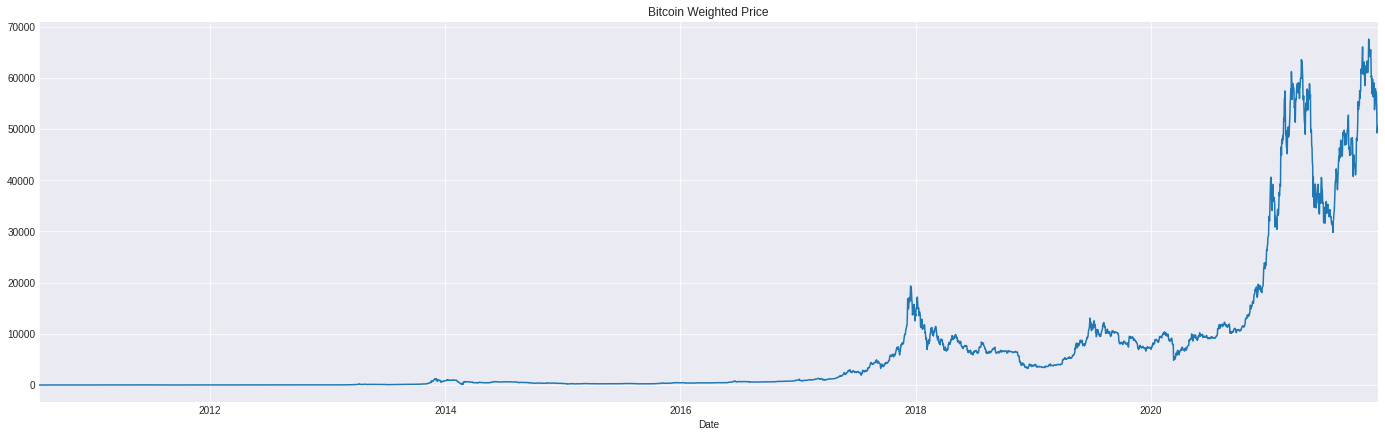

In [11]:
btc_input_df_datetype.set_index("Date").Price.plot(figsize=(24,7), title="Bitcoin Weighted Price")

No handles with labels found to put in legend.


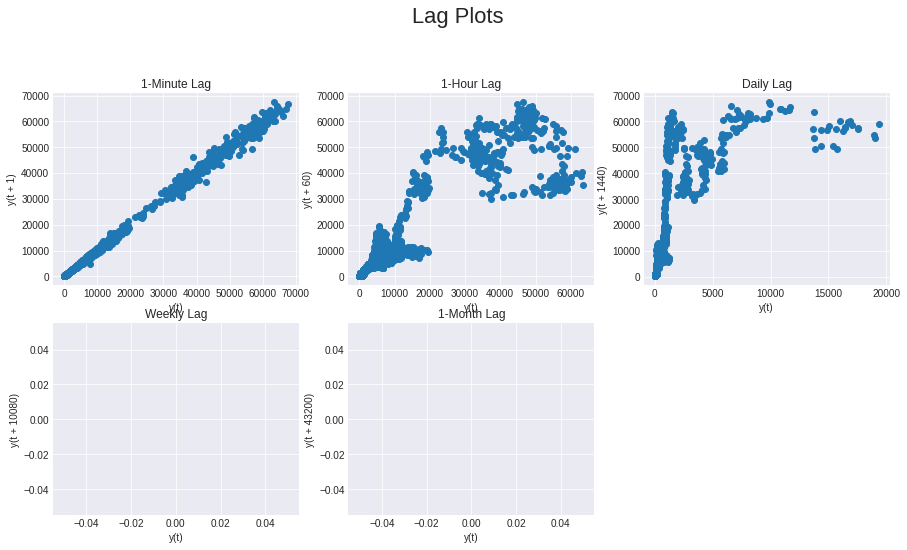

In [12]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['Price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['Price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['Price'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [13]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['Date'], unit='s').dt.date

display(btc_input_df_datetype.head())

,Sno,Date,Price,Open,High,Low,Vol.,Change %,Google,Fear_greed_ratio,Fear_greed,date
0,1,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0,1.0,NaN,NaN,2010-07-18
1,2,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,1.0,NaN,NaN,2010-07-19
2,3,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,1.0,NaN,NaN,2010-07-20
3,4,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,1.0,NaN,NaN,2010-07-21
4,5,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,1.0,NaN,NaN,2010-07-22


In [14]:
group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['Price'].mean()

In [15]:
btc_closing_price_groupby_date.head()

date
2010-07-18    0.1
2010-07-19    0.1
2010-07-20    0.1
2010-07-21    0.1
2010-07-22    0.1
Name: Price, dtype: float64

In [16]:
btc_closing_price_groupby_date.shape

(4161,)

In [17]:
prediction_days = 60

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [18]:
df_train.shape

(4101, 1)

In [19]:
df_test.shape

(60, 1)

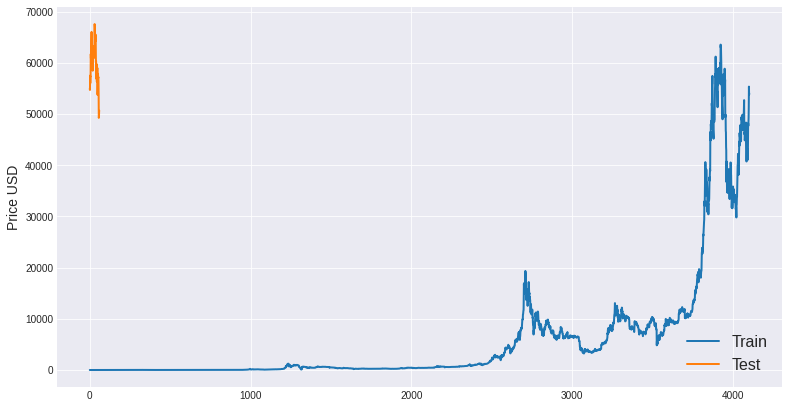

In [20]:
chosen_col = 'Price'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [21]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [22]:
scaled_train

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.87092671],
       [0.84666419],
       [0.84927669]])

In [23]:
scaled_test


array([[0.31239803],
       [0.29755888],
       [0.45028099],
       [0.36933949],
       [0.44372197],
       [0.44329552],
       [0.68005135],
       [0.63538702],
       [0.67086261],
       [0.69899998],
       [0.82244459],
       [0.9165489 ],
       [0.70782452],
       [0.6250243 ],
       [0.65846207],
       [0.63413441],
       [0.75584971],
       [0.60591185],
       [0.50313918],
       [0.61978287],
       [0.71179422],
       [0.6908094 ],
       [0.66084662],
       [0.63932505],
       [0.76584058],
       [0.74776124],
       [0.66635178],
       [0.64241618],
       [0.67152878],
       [0.7681678 ],
       [1.        ],
       [0.96668181],
       [0.85570163],
       [0.84998952],
       [0.81396789],
       [0.82773407],
       [0.88807189],
       [0.78539314],
       [0.59337262],
       [0.6066703 ],
       [0.41809529],
       [0.48493916],
       [0.57441306],
       [0.51491942],
       [0.38439432],
       [0.45461708],
       [0.43254675],
       [0.532

In [24]:
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)


print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (4096, 5)
trainY:  (4096,)
testX:  (55, 5)
testY (55,)


In [25]:
print("trainX: ", trainX)

trainX:  [[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.75802728 0.75003132 0.75910108 0.77502077 0.8104067 ]
 [0.75003132 0.75910108 0.77502077 0.8104067  0.87092671]
 [0.75910108 0.77502077 0.8104067  0.87092671 0.84666419]]


In [26]:
print("trainY: ", trainY)

trainY:  [0.         0.         0.         ... 0.87092671 0.84666419 0.84927669]


In [27]:
print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (4096, 5)
trainY:  (4096,)
testX:  (55, 5)
testY (55,)


In [28]:
print("testX: ", testX)
print("testY", testY.shape)

testX:  [[0.31239803 0.29755888 0.45028099 0.36933949 0.44372197]
 [0.29755888 0.45028099 0.36933949 0.44372197 0.44329552]
 [0.45028099 0.36933949 0.44372197 0.44329552 0.68005135]
 [0.36933949 0.44372197 0.44329552 0.68005135 0.63538702]
 [0.44372197 0.44329552 0.68005135 0.63538702 0.67086261]
 [0.44329552 0.68005135 0.63538702 0.67086261 0.69899998]
 [0.68005135 0.63538702 0.67086261 0.69899998 0.82244459]
 [0.63538702 0.67086261 0.69899998 0.82244459 0.9165489 ]
 [0.67086261 0.69899998 0.82244459 0.9165489  0.70782452]
 [0.69899998 0.82244459 0.9165489  0.70782452 0.6250243 ]
 [0.82244459 0.9165489  0.70782452 0.6250243  0.65846207]
 [0.9165489  0.70782452 0.6250243  0.65846207 0.63413441]
 [0.70782452 0.6250243  0.65846207 0.63413441 0.75584971]
 [0.6250243  0.65846207 0.63413441 0.75584971 0.60591185]
 [0.65846207 0.63413441 0.75584971 0.60591185 0.50313918]
 [0.63413441 0.75584971 0.60591185 0.50313918 0.61978287]
 [0.75584971 0.60591185 0.50313918 0.61978287 0.71179422]
 [0.60

In [29]:
print("testY", testY)

testY [0.44329552 0.68005135 0.63538702 0.67086261 0.69899998 0.82244459
 0.9165489  0.70782452 0.6250243  0.65846207 0.63413441 0.75584971
 0.60591185 0.50313918 0.61978287 0.71179422 0.6908094  0.66084662
 0.63932505 0.76584058 0.74776124 0.66635178 0.64241618 0.67152878
 0.7681678  1.         0.96668181 0.85570163 0.84998952 0.81396789
 0.82773407 0.88807189 0.78539314 0.59337262 0.6066703  0.41809529
 0.48493916 0.57441306 0.51491942 0.38439432 0.45461708 0.43254675
 0.53217751 0.24662111 0.30130034 0.44098359 0.4694262  0.423008
 0.43603266 0.39753474 0.24008885 0.         0.0132742  0.07035381
 0.07559141]


In [30]:
from numpy import array
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
data = data.reshape((1, 10, 1))
print(data.shape)

(1, 10, 1)


In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(10, 1)))
model.add(Dense(1))

In [ ]:
print(trainX.shape)

(2028, 5)


In [ ]:
print(trainY.shape)

(2028,)


In [ ]:
trainX.shape[0]

2028

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (2028, 5, 1)
Shape of testX:  (55, 5, 1)


In [ ]:
trainX

array([[[0.00121363],
        [0.00126169],
        [0.0014948 ],
        [0.0020115 ],
        [0.00139387]],

       [[0.00126169],
        [0.0014948 ],
        [0.0020115 ],
        [0.00139387],
        [0.00152845]],

       [[0.0014948 ],
        [0.0020115 ],
        [0.00139387],
        [0.00152845],
        [0.00148519]],

       ...,

       [[0.70109443],
        [0.73394648],
        [0.70139723],
        [0.67264989],
        [0.68334182]],

       [[0.73394648],
        [0.70139723],
        [0.67264989],
        [0.68334182],
        [0.71946706]],

       [[0.70139723],
        [0.67264989],
        [0.68334182],
        [0.71946706],
        [0.79413518]]])

In [ ]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Note - If I plan to add 3-rd or 4-th layers of LSTM then 
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
# callbacks = [checkpoint]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/600
62/64 [============================>.] - ETA: 0s - loss: 0.0225
Epoch 00001: val_loss improved from inf to 0.07111, saving model to my_best_model.hdf5
64/64 [==============================] - 6s 33ms/step - loss: 0.0266 - val_loss: 0.0711
Epoch 2/600
63/64 [============================>.] - ETA: 0s - loss: 0.0112
Epoch 00002: val_loss improved from 0.07111 to 0.02605, saving model to my_best_model.hdf5
64/64 [==============================] - 1s 16ms/step - loss: 0.0112 - val_loss: 0.0261
Epoch 3/600
61/64 [===========================>..] - ETA: 0s - loss: 0.0018
Epoch 00003: val_loss improved from 0.02605 to 0.02058, saving model to my_best_model.hdf5
64/64 [==============================] - 1s 16ms/step - loss: 0.0021 - val_loss: 0.0206
Epoch 4/600
63/64 [============================>.] - ETA: 0s - loss: 0.0012    
Epoch 00004: val_loss improved from 0.02058 to 0.01720, saving model to my_best_model.hdf5
64/64 [==============================] - 1s 16ms/step - loss: 0.0012

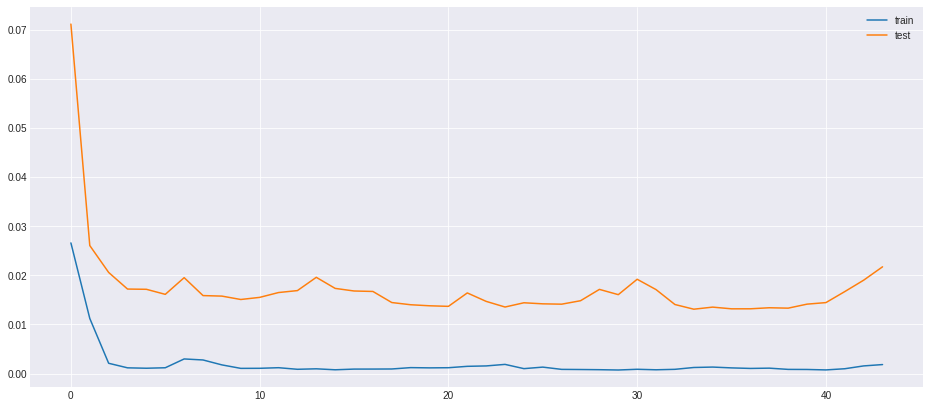

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)

from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

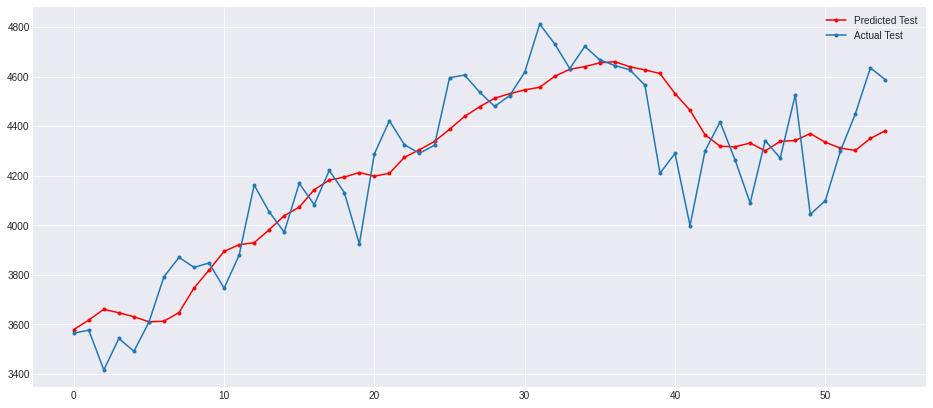

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [ ]:
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

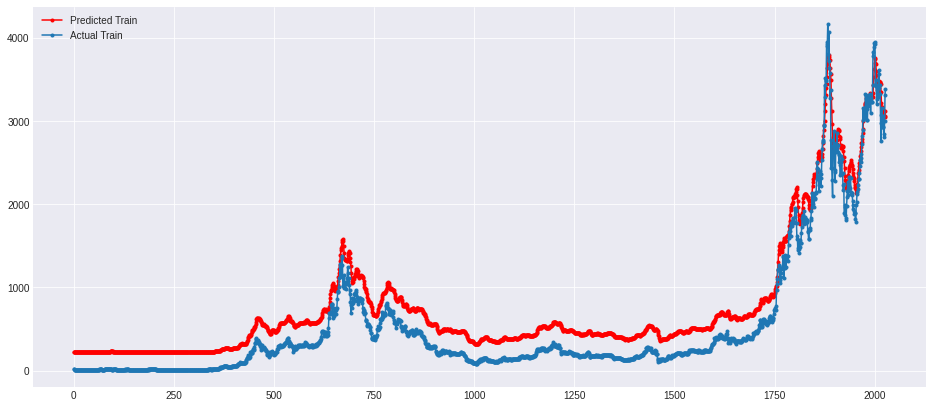

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

In [ ]:

predicted = []
test=[]
verschil = []

for i in predicted_btc_price_test_data:
  predicted.append(i)
for i in test_actual:
  test.append(i)

for i in range(test_actual.size):
  waarde = ((predicted_btc_price_test_data[i]-test_actual[i])/predicted_btc_price_test_data[i])*100
  if waarde <0:
    resultaat = 100+((predicted_btc_price_test_data[i]-test_actual[i])/predicted_btc_price_test_data[i])*100
  else:
    resultaat = 100-((predicted_btc_price_test_data[i]-test_actual[i])/predicted_btc_price_test_data[i])*100
  verschil.append(resultaat)
verschil




[array([99.59948073]),
 array([98.86125675]),
 array([93.30330357]),
 array([97.15407047]),
 array([96.15596142]),
 array([99.95758114]),
 array([95.02795426]),
 array([93.88670087]),
 array([97.7680037]),
 array([99.24961543]),
 array([96.18442549]),
 array([98.90980133]),
 array([94.07225886]),
 array([98.17718184]),
 array([98.34998903]),
 array([97.64195183]),
 array([98.53497883]),
 array([99.06822185]),
 array([98.50870503]),
 array([93.14931714]),
 array([97.84031561]),
 array([94.97072253]),
 array([98.81077178]),
 array([99.66949456]),
 array([99.65306248]),
 array([95.25694047]),
 array([96.23489915]),
 array([98.68032413]),
 array([99.2653587]),
 array([99.83166039]),
 array([98.4394492]),
 array([94.40007132]),
 array([97.16200956]),
 array([99.93591662]),
 array([98.23669548]),
 array([99.74899977]),
 array([99.66826664]),
 array([99.73671083]),
 array([98.66570871]),
 array([91.26558749]),
 array([94.66339595]),
 array([89.56207742]),
 array([98.5034707]),
 array([97.7251

In [ ]:
def Average(vershil):
    return sum(vershil) / len(vershil)
average = Average(verschil)
average

array([97.09107851])

In [ ]:
train_actual[1]

array([12.88])

In [ ]:
predicted_btc_price_train_data[1]

array([227.12216], dtype=float32)

rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

Test RMSE: 258.763


In [ ]:
testX

array([[[0.02307152],
        [0.        ],
        [0.08991367],
        [0.13241384],
        [0.14129992]],

       [[0.        ],
        [0.08991367],
        [0.13241384],
        [0.14129992],
        [0.12406822]],

       [[0.08991367],
        [0.13241384],
        [0.14129992],
        [0.12406822],
        [0.1323998 ]],

       [[0.13241384],
        [0.14129992],
        [0.12406822],
        [0.1323998 ],
        [0.01951288]],

       [[0.14129992],
        [0.12406822],
        [0.1323998 ],
        [0.01951288],
        [0.10891416]],

       [[0.12406822],
        [0.1323998 ],
        [0.01951288],
        [0.10891416],
        [0.0725837 ]],

       [[0.1323998 ],
        [0.01951288],
        [0.10891416],
        [0.0725837 ],
        [0.1551274 ]],

       [[0.01951288],
        [0.10891416],
        [0.0725837 ],
        [0.1551274 ],
        [0.28389135]],

       [[0.10891416],
        [0.0725837 ],
        [0.1551274 ],
        [0.28389135],
        [0.33868

In [ ]:
testX.shape

(55, 5, 1)

In [ ]:
loopback_period = 10

testX_last_10_days = testX[testX.shape[0] - loopback_period : ]

testX_last_10_days.shape

(10, 5, 1)

In [ ]:
testX_last_10_days

array([[[0.63325612],
        [0.4286727 ],
        [0.64038043],
        [0.72260125],
        [0.61471889]],

       [[0.4286727 ],
        [0.64038043],
        [0.72260125],
        [0.61471889],
        [0.49270724]],

       [[0.64038043],
        [0.72260125],
        [0.61471889],
        [0.49270724],
        [0.66990945]],

       [[0.72260125],
        [0.61471889],
        [0.49270724],
        [0.66990945],
        [0.62015863]],

       [[0.61471889],
        [0.49270724],
        [0.66990945],
        [0.62015863],
        [0.79923493]],

       [[0.49270724],
        [0.66990945],
        [0.62015863],
        [0.79923493],
        [0.46077771]],

       [[0.66990945],
        [0.62015863],
        [0.79923493],
        [0.46077771],
        [0.49912964]],

       [[0.62015863],
        [0.79923493],
        [0.46077771],
        [0.49912964],
        [0.63955921]],

       [[0.79923493],
        [0.46077771],
        [0.49912964],
        [0.63955921],
        [0.74557

In [ ]:
 predicted_10_days_forecast_price_test_x = []

for i in range(10):  
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_10_days[i:i+1])
  
  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_10_days_forecast_price_test_x.append(predicted_forecast_price_test_x)
  
print("Forecast for the next 10 Days Beyond the actual trading days ", np.array(predicted_10_days_forecast_price_test_x)) 
# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast beyond 30-Oct-2021

Forecast for the next 10 Days Beyond the actual trading days  [[[4331.504 ]]

 [[4299.76  ]]

 [[4338.3965]]

 [[4341.7974]]

 [[4369.773 ]]

 [[4334.733 ]]

 [[4310.852 ]]

 [[4302.0146]]

 [[4350.0327]]

 [[4381.476 ]]]


In [ ]:
predicted_10_days_forecast_price_test_x = np.array(predicted_10_days_forecast_price_test_x)

predicted_10_days_forecast_price_test_x.shape

(10, 1, 1)

In [ ]:
predicted_btc_price_test_data.shape

(55, 1)

In [ ]:
predicted_btc_price_test_data

array([[3578.2917],
       [3617.0186],
       [3660.1062],
       [3646.1365],
       [3630.1545],
       [3609.7412],
       [3612.0664],
       [3646.7908],
       [3746.0483],
       [3818.5264],
       [3894.0608],
       [3920.9158],
       [3929.0369],
       [3981.3276],
       [4038.1804],
       [4072.5278],
       [4143.341 ],
       [4181.9634],
       [4194.015 ],
       [4212.527 ],
       [4197.605 ],
       [4209.5215],
       [4273.844 ],
       [4304.386 ],
       [4337.94  ],
       [4386.935 ],
       [4438.9395],
       [4478.054 ],
       [4512.6216],
       [4530.787 ],
       [4546.076 ],
       [4556.7266],
       [4601.0137],
       [4629.2534],
       [4640.052 ],
       [4655.6543],
       [4659.8984],
       [4639.2446],
       [4626.795 ],
       [4612.363 ],
       [4531.213 ],
       [4463.8647],
       [4364.8716],
       [4318.453 ],
       [4316.4746],
       [4331.504 ],
       [4299.76  ],
       [4338.3965],
       [4341.798 ],
       [4369.7725],


In [ ]:
predicted_10_days_forecast_price_test_x

array([[[4331.504 ]],

       [[4299.76  ]],

       [[4338.3965]],

       [[4341.7974]],

       [[4369.773 ]],

       [[4334.733 ]],

       [[4310.852 ]],

       [[4302.0146]],

       [[4350.0327]],

       [[4381.476 ]]], dtype=float32)

In [ ]:
predicted_10_days_forecast_price_test_x = predicted_10_days_forecast_price_test_x.flatten()

predicted_10_days_forecast_price_test_x

array([4331.504 , 4299.76  , 4338.3965, 4341.7974, 4369.773 , 4334.733 ,
       4310.852 , 4302.0146, 4350.0327, 4381.476 ], dtype=float32)

In [ ]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

predicted_btc_price_test_data

array([3578.2917, 3617.0186, 3660.1062, 3646.1365, 3630.1545, 3609.7412,
       3612.0664, 3646.7908, 3746.0483, 3818.5264, 3894.0608, 3920.9158,
       3929.0369, 3981.3276, 4038.1804, 4072.5278, 4143.341 , 4181.9634,
       4194.015 , 4212.527 , 4197.605 , 4209.5215, 4273.844 , 4304.386 ,
       4337.94  , 4386.935 , 4438.9395, 4478.054 , 4512.6216, 4530.787 ,
       4546.076 , 4556.7266, 4601.0137, 4629.2534, 4640.052 , 4655.6543,
       4659.8984, 4639.2446, 4626.795 , 4612.363 , 4531.213 , 4463.8647,
       4364.8716, 4318.453 , 4316.4746, 4331.504 , 4299.76  , 4338.3965,
       4341.798 , 4369.7725, 4334.733 , 4310.852 , 4302.0146, 4350.032 ,
       4381.476 ], dtype=float32)

In [ ]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_10_days_forecast_price_test_x))

predicted_btc_test_concatenated

predicted_btc_test_concatenated.shape

(65,)

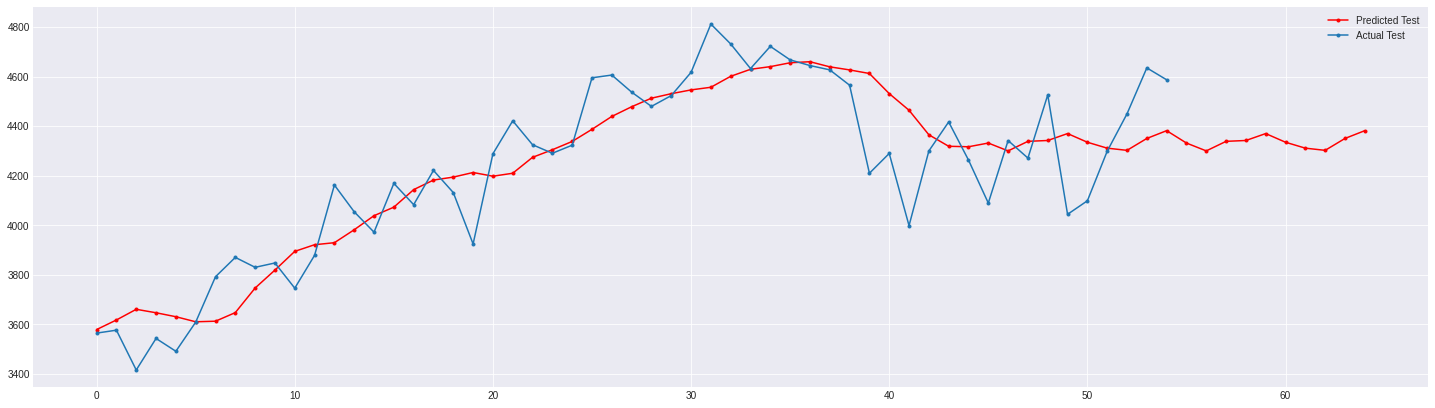

In [ ]:
plt.figure(figsize=(25,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()